In [30]:
# Import required libraries
import pandas as pd
import json
import os
from openai import OpenAI
import time
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load and Sample Dataset

In [31]:
df = pd.read_csv('yelp.csv')  # Update path as needed

print(f"Total reviews in dataset: {len(df)}")
print(f"\nDataset columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Total reviews in dataset: 10000

Dataset columns: ['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id', 'cool', 'useful', 'funny']

First few rows:


,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


Sample size: 200

Rating distribution in sample:
stars
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64


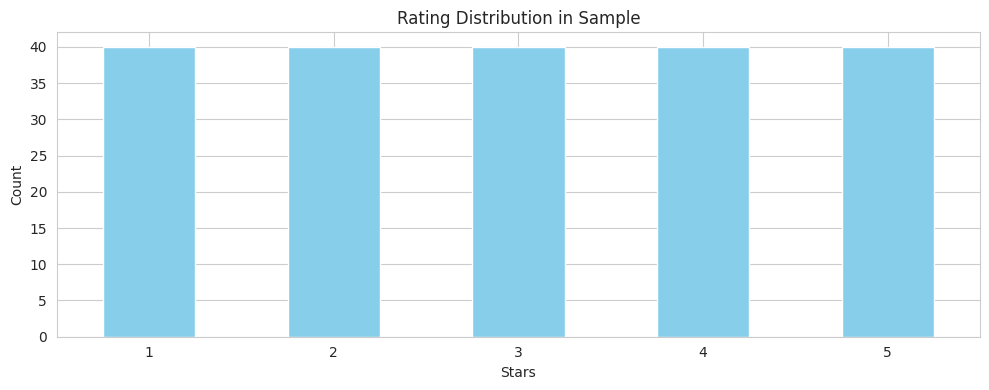

In [32]:
# Sample 200 rows for evaluation (as recommended)
SAMPLES_PER_STAR = 40 # Set the number of samples per star rating
sample_df = df.groupby('stars', group_keys=False).apply(lambda x: x.sample(min(len(x), SAMPLES_PER_STAR), random_state=42)).reset_index(drop=True)

print(f"Sample size: {len(sample_df)}")
print(f"\nRating distribution in sample:")
print(sample_df['stars'].value_counts().sort_index())

# Visualize distribution
plt.figure(figsize=(10, 4))
sample_df['stars'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Rating Distribution in Sample')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 2. Setup LLM Client

Using OpenRouter API with free models (or you can use Gemini API)

In [33]:
# Setup OpenRouter client
# Get your API key from https://openrouter.ai/
OPENROUTER_API_KEY =key

client = OpenAI(
    api_key=OPENROUTER_API_KEY,
    base_url="https://openrouter.ai/api/v1"
)

# Using a free model - you can change this
MODEL = "openai/gpt-4o-mini"  # Free tier available
# Alternative free models:
# MODEL = "meta-llama/llama-3.1-8b-instruct:free"
# MODEL = "google/gemini-flash-1.5"

print(f"Using model: {MODEL}")

Using model: openai/gpt-4o-mini


## 3. Prompt Design - Three Approaches

### Approach 1: Basic Zero-Shot Prompting
Simple, direct instruction without examples or detailed guidelines.

In [34]:
def prompt_approach_1(review_text: str) -> str:
    """
    Approach 1: Basic Zero-Shot
    Simple instruction with minimal guidance.
    """
    return f"""Analyze this Yelp review and predict the star rating (1-5).
Return your response as JSON with this exact format:
{{
  "predicted_stars": <number>,
  "explanation": "<brief reason>"
}}

Review: {review_text}

Return only the JSON, no other text."""

# Test with one example
test_review = sample_df.iloc[0]['text']
print("Test Review:", test_review[:200], "...")
print("\nPrompt:")
print(prompt_approach_1(test_review))

Test Review: An upscale mexican restaurant in the area seemed like the best thing to have happened to me. I planned my visit for a quieter evening, and reviewed the menu again and again. 

However, upon our arriva ...

Prompt:
Analyze this Yelp review and predict the star rating (1-5).
Return your response as JSON with this exact format:
{
  "predicted_stars": <number>,
  "explanation": "<brief reason>"
}

Review: An upscale mexican restaurant in the area seemed like the best thing to have happened to me. I planned my visit for a quieter evening, and reviewed the menu again and again. 

However, upon our arrival I thought twice immediately. The parking was iffy, and the place didn't seem to stand up to the signage. Perhaps the art was not to my liking, honestly not a piece stands out in my memory. 


We were seated immediately. 

Our waiter seemed a little off, not to mention the fact that he was insanely snobby and seemed to be moonlighting in the kitchen, where he disappeared for 10-

### Approach 2: Enhanced with Sentiment Indicators
Provides explicit sentiment cues and rating guidelines.

In [35]:
def prompt_approach_2(review_text: str) -> str:
    """
    Approach 2: Enhanced with Sentiment Guidelines
    Provides explicit sentiment indicators for each rating level.
    """
    return f"""You are a sentiment analysis expert. Analyze this Yelp review and predict the star rating.

Rating Guidelines:
- 5 stars: Extremely positive, enthusiastic, highly recommends
- 4 stars: Positive with minor issues or room for improvement
- 3 stars: Mixed feelings, neutral, "it was okay"
- 2 stars: Mostly negative with few redeeming qualities
- 1 star: Extremely negative, very disappointed, would not recommend

Consider:
- Overall sentiment (positive/negative words)
- Specific complaints or praises
- Whether they would recommend it
- Intensity of emotions expressed

Review: {review_text}

Return ONLY valid JSON in this exact format:
{{
  "predicted_stars": <number 1-5>,
  "explanation": "<brief reasoning in 1-2 sentences>"
}}"""

print("Approach 2 Prompt Example:")
print(prompt_approach_2("Great food, amazing service!"))

Approach 2 Prompt Example:
You are a sentiment analysis expert. Analyze this Yelp review and predict the star rating.

Rating Guidelines:
- 5 stars: Extremely positive, enthusiastic, highly recommends
- 4 stars: Positive with minor issues or room for improvement
- 3 stars: Mixed feelings, neutral, "it was okay"
- 2 stars: Mostly negative with few redeeming qualities
- 1 star: Extremely negative, very disappointed, would not recommend

Consider:
- Overall sentiment (positive/negative words)
- Specific complaints or praises
- Whether they would recommend it
- Intensity of emotions expressed

Review: Great food, amazing service!

Return ONLY valid JSON in this exact format:
{
  "predicted_stars": <number 1-5>,
  "explanation": "<brief reasoning in 1-2 sentences>"
}


### Approach 3: Few-Shot with Examples
Provides concrete examples for each rating level to guide the model.

In [36]:
def prompt_approach_3(review_text: str) -> str:
    """
    Approach 3: Few-Shot Learning with Examples
    Provides concrete examples for each rating level.
    """
    return f"""Analyze this Yelp review and predict the star rating (1-5). Use these examples as reference:

Example 1 (5 stars):
Review: "Absolutely amazing! The food was incredible and the service was outstanding. Will definitely come back!"
Rating: 5 - Highly enthusiastic and would return

Example 2 (4 stars):
Review: "Really good food and nice atmosphere. Service was a bit slow but overall a great experience."
Rating: 4 - Positive with minor issue noted

Example 3 (3 stars):
Review: "It was okay. Nothing special but not bad either. Prices are reasonable."
Rating: 3 - Neutral, neither impressed nor disappointed

Example 4 (2 stars):
Review: "Disappointed with the quality. Food was cold and staff seemed uninterested. Might have been an off day."
Rating: 2 - Mostly negative experience with small concession

Example 5 (1 star):
Review: "Terrible experience. Rude staff, horrible food, overpriced. Never coming back and don't recommend."
Rating: 1 - Extremely negative, would not recommend

Now analyze this review:
Review: {review_text}

Return ONLY valid JSON:
{{
  "predicted_stars": <number 1-5>,
  "explanation": "<reasoning based on sentiment indicators>"
}}"""

## 4. Helper Functions for Evaluation

In [37]:
def call_llm(prompt: str, temperature: float = 0.3, max_retries: int = 3) -> Dict:
    """
    Call the LLM API with retry logic.
    """
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=MODEL,
                messages=[{"role": "user", "content": prompt}],
                temperature=temperature,
                response_format={"type": "json_object"}
            )

            content = response.choices[0].message.content
            result = json.loads(content)

            # Validate required fields
            if "predicted_stars" not in result or "explanation" not in result:
                raise ValueError("Missing required fields in JSON response")

            # Validate rating range
            stars = int(result["predicted_stars"])
            if stars < 1 or stars > 5:
                raise ValueError(f"Invalid rating: {stars}")

            return {
                "predicted_stars": stars,
                "explanation": result["explanation"],
                "valid_json": True,
                "error": None
            }

        except json.JSONDecodeError as e:
            if attempt == max_retries - 1:
                return {"predicted_stars": None, "explanation": None, "valid_json": False, "error": "Invalid JSON"}
            time.sleep(1)
        except Exception as e:
            if attempt == max_retries - 1:
                return {"predicted_stars": None, "explanation": None, "valid_json": False, "error": str(e)}
            time.sleep(1)

    return {"predicted_stars": None, "explanation": None, "valid_json": False, "error": "Max retries exceeded"}


def evaluate_approach(df: pd.DataFrame, prompt_func, approach_name: str) -> Dict:
    """
    Evaluate a prompting approach on the dataset.
    """
    print(f"\n{'='*60}")
    print(f"Evaluating: {approach_name}")
    print(f"{'='*60}")

    results = []
    valid_json_count = 0

    for idx, row in df.iterrows():
        print(f"Processing {idx + 1}/{len(df)}...", end='\r')

        prompt = prompt_func(row['text'])
        result = call_llm(prompt)

        if result['valid_json']:
            valid_json_count += 1

        results.append({
            'actual_stars': row['stars'],
            'predicted_stars': result['predicted_stars'],
            'explanation': result['explanation'],
            'valid_json': result['valid_json'],
            'error': result['error']
        })

        # Rate limiting - be nice to the API
        time.sleep(0.5)

    print(f"\nCompleted {len(df)} predictions.")

    # Calculate metrics
    results_df = pd.DataFrame(results)
    valid_results = results_df[results_df['valid_json'] == True]

    if len(valid_results) > 0:
        accuracy = accuracy_score(valid_results['actual_stars'], valid_results['predicted_stars'])
        json_validity_rate = (valid_json_count / len(df)) * 100
    else:
        accuracy = 0
        json_validity_rate = 0

    return {
        'approach': approach_name,
        'accuracy': accuracy,
        'json_validity_rate': json_validity_rate,
        'valid_predictions': len(valid_results),
        'total_predictions': len(df),
        'results_df': results_df
    }

## 5. Run Evaluations

Running all three approaches will make ~600 API calls. This may take 10-20 minutes.

In [38]:
# Evaluate Approach 1
results_1 = evaluate_approach(sample_df, prompt_approach_1, "Approach 1: Basic Zero-Shot")


Evaluating: Approach 1: Basic Zero-Shot

Completed 200 predictions.


In [39]:
# Evaluate Approach 2
results_2 = evaluate_approach(sample_df, prompt_approach_2, "Approach 2: Enhanced with Sentiment Guidelines")


Evaluating: Approach 2: Enhanced with Sentiment Guidelines

Completed 200 predictions.


In [40]:
# Evaluate Approach 3
results_3 = evaluate_approach(sample_df, prompt_approach_3, "Approach 3: Few-Shot with Examples")


Evaluating: Approach 3: Few-Shot with Examples

Completed 200 predictions.


## 6. Comparison and Analysis

In [41]:
# Create comparison table
comparison_df = pd.DataFrame([
    {
        'Approach': results_1['approach'],
        'Accuracy (%)': f"{results_1['accuracy'] * 100:.2f}",
        'JSON Validity (%)': f"{results_1['json_validity_rate']:.2f}",
        'Valid Predictions': results_1['valid_predictions'],
        'Total Attempts': results_1['total_predictions']
    },
    {
        'Approach': results_2['approach'],
        'Accuracy (%)': f"{results_2['accuracy'] * 100:.2f}",
        'JSON Validity (%)': f"{results_2['json_validity_rate']:.2f}",
        'Valid Predictions': results_2['valid_predictions'],
        'Total Attempts': results_2['total_predictions']
    },
    {
        'Approach': results_3['approach'],
        'Accuracy (%)': f"{results_3['accuracy'] * 100:.2f}",
        'JSON Validity (%)': f"{results_3['json_validity_rate']:.2f}",
        'Valid Predictions': results_3['valid_predictions'],
        'Total Attempts': results_3['total_predictions']
    }
])

print("\n" + "="*80)
print("COMPARISON TABLE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


COMPARISON TABLE
                                      Approach Accuracy (%) JSON Validity (%)  Valid Predictions  Total Attempts
                   Approach 1: Basic Zero-Shot        68.50            100.00                200             200
Approach 2: Enhanced with Sentiment Guidelines        66.50            100.00                200             200
            Approach 3: Few-Shot with Examples        66.50            100.00                200             200


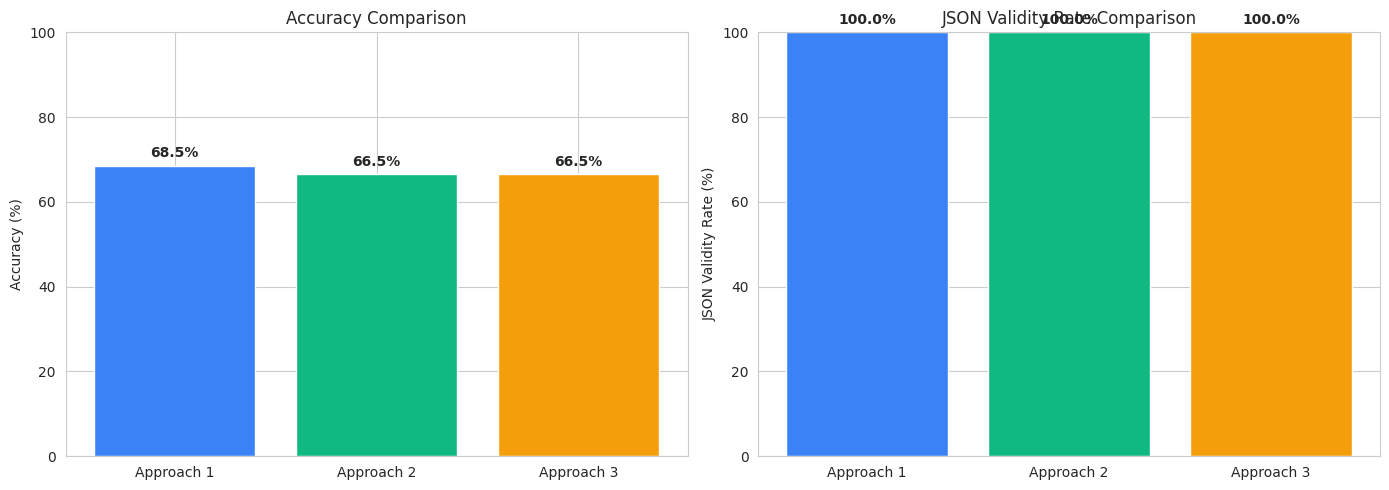

In [42]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
approaches = ['Approach 1', 'Approach 2', 'Approach 3']
accuracies = [results_1['accuracy'] * 100, results_2['accuracy'] * 100, results_3['accuracy'] * 100]
axes[0].bar(approaches, accuracies, color=['#3b82f6', '#10b981', '#f59e0b'])
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylim([0, 100])
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# JSON Validity comparison
json_rates = [results_1['json_validity_rate'], results_2['json_validity_rate'], results_3['json_validity_rate']]
axes[1].bar(approaches, json_rates, color=['#3b82f6', '#10b981', '#f59e0b'])
axes[1].set_ylabel('JSON Validity Rate (%)')
axes[1].set_title('JSON Validity Rate Comparison')
axes[1].set_ylim([0, 100])
for i, v in enumerate(json_rates):
    axes[1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

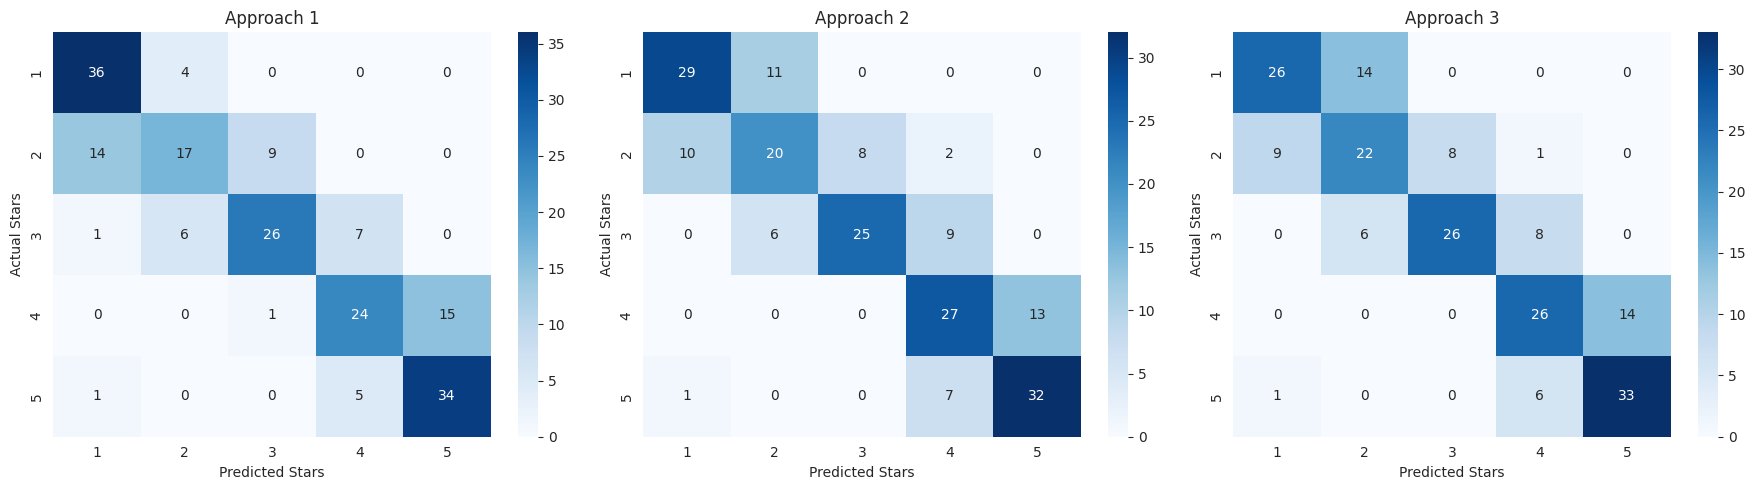

In [43]:
# Confusion matrices for each approach
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (results, ax) in enumerate([(results_1, axes[0]), (results_2, axes[1]), (results_3, axes[2])]):
    valid_results = results['results_df'][results['results_df']['valid_json'] == True]
    if len(valid_results) > 0:
        cm = confusion_matrix(valid_results['actual_stars'], valid_results['predicted_stars'], labels=[1, 2, 3, 4, 5])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
        ax.set_title(f'Approach {idx + 1}')
        ax.set_ylabel('Actual Stars')
        ax.set_xlabel('Predicted Stars')

plt.tight_layout()
plt.show()

## 7. Detailed Classification Reports

In [44]:
# Classification report for best performing approach
for results in [results_1, results_2, results_3]:
    print(f"\n{'='*60}")
    print(f"Classification Report: {results['approach']}")
    print(f"{'='*60}")
    valid_results = results['results_df'][results['results_df']['valid_json'] == True]
    if len(valid_results) > 0:
        print(classification_report(valid_results['actual_stars'], valid_results['predicted_stars'],
                                     labels=[1, 2, 3, 4, 5], target_names=['1 star', '2 stars', '3 stars', '4 stars', '5 stars']))
    else:
        print("No valid predictions to analyze.")


Classification Report: Approach 1: Basic Zero-Shot
              precision    recall  f1-score   support

      1 star       0.69      0.90      0.78        40
     2 stars       0.63      0.42      0.51        40
     3 stars       0.72      0.65      0.68        40
     4 stars       0.67      0.60      0.63        40
     5 stars       0.69      0.85      0.76        40

    accuracy                           0.69       200
   macro avg       0.68      0.69      0.67       200
weighted avg       0.68      0.69      0.67       200


Classification Report: Approach 2: Enhanced with Sentiment Guidelines
              precision    recall  f1-score   support

      1 star       0.72      0.72      0.72        40
     2 stars       0.54      0.50      0.52        40
     3 stars       0.76      0.62      0.68        40
     4 stars       0.60      0.68      0.64        40
     5 stars       0.71      0.80      0.75        40

    accuracy                           0.67       200
   macro

## 8. Discussion and Analysis

### Key Findings:

**Approach 1 (Basic Zero-Shot):**
- **Pros**: Simplest prompt, fastest to execute
- **Cons**: May lack context for nuanced reviews, potential inconsistency
- **Best for**: Simple, clear-cut reviews with obvious sentiment

**Approach 2 (Enhanced with Sentiment Guidelines):**
- **Pros**: Provides clear rating criteria, better consistency
- **Cons**: Longer prompt, slightly slower
- **Best for**: Reviews with mixed sentiments or subtle cues

**Approach 3 (Few-Shot with Examples):**
- **Pros**: Most context, examples guide the model effectively
- **Cons**: Longest prompt, highest token usage
- **Best for**: When accuracy is critical and token cost is acceptable


## 9. Sample Predictions Analysis

In [45]:
# Show some example predictions from the best approach
best_results = results_3  # Change this based on your results
valid_results = best_results['results_df'][best_results['results_df']['valid_json'] == True]

print("\n" + "="*80)
print("SAMPLE PREDICTIONS (Correct)")
print("="*80)

correct_predictions = valid_results[valid_results['actual_stars'] == valid_results['predicted_stars']].head(3)
for idx, row in correct_predictions.iterrows():
    print(f"\nActual: {row['actual_stars']} stars | Predicted: {row['predicted_stars']} stars ✓")
    print(f"Explanation: {row['explanation']}")
    print("-" * 80)

print("\n" + "="*80)
print("SAMPLE PREDICTIONS (Incorrect)")
print("="*80)

incorrect_predictions = valid_results[valid_results['actual_stars'] != valid_results['predicted_stars']].head(3)
for idx, row in incorrect_predictions.iterrows():
    print(f"\nActual: {row['actual_stars']} stars | Predicted: {row['predicted_stars']} stars ✗")
    print(f"Explanation: {row['explanation']}")
    print("-" * 80)


SAMPLE PREDICTIONS (Correct)

Actual: 1 stars | Predicted: 1 stars ✓
Explanation: The review expresses a highly negative experience, highlighting poor service, overpriced food, and dissatisfaction with the quality of the sushi. The reviewer indicates they would not return and had a frustrating time, which aligns with a 1-star rating.
--------------------------------------------------------------------------------

Actual: 1 stars | Predicted: 1 stars ✓
Explanation: The review expresses extreme dissatisfaction with the quality of the food, specifically mentioning the small size of the wings and a lack of flavor choices. The reviewer clearly states they will never return, indicating a very negative experience.
--------------------------------------------------------------------------------

Actual: 1 stars | Predicted: 1 stars ✓
Explanation: The review expresses extreme frustration and anger towards the staff's lack of assistance and the store's organization. The reviewer mentions being

## 10. Summary Statistics

In [46]:
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

print(f"\nDataset Size: {len(sample_df)} reviews")
print(f"Models Tested: 3 prompting approaches")
print(f"\nBest Performing Approach:")

all_results = [results_1, results_2, results_3]
best = max(all_results, key=lambda x: x['accuracy'])

print(f"  - {best['approach']}")
print(f"  - Accuracy: {best['accuracy'] * 100:.2f}%")
print(f"  - JSON Validity: {best['json_validity_rate']:.2f}%")
print(f"\nKey Insights:")
print("  - More structured prompts generally improve consistency")
print("  - Few-shot examples help with edge cases")
print("  - JSON format enforcement is critical for reliability")
print("  - Temperature tuning affects prediction consistency")

print("\n" + "="*80)


FINAL SUMMARY

Dataset Size: 200 reviews
Models Tested: 3 prompting approaches

Best Performing Approach:
  - Approach 1: Basic Zero-Shot
  - Accuracy: 68.50%
  - JSON Validity: 100.00%

Key Insights:
  - More structured prompts generally improve consistency
  - Few-shot examples help with edge cases
  - JSON format enforcement is critical for reliability
  - Temperature tuning affects prediction consistency

